torch.Size([1, 1, 28, 28])


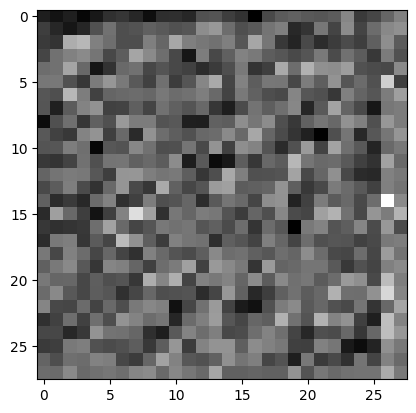

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

class LabelImageCNN(nn.Module):
    def __init__(self, device):
        super(LabelImageCNN, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(10, 50)  # Embedding 10 classes to a 50-dimensional space
        self.fc1 = nn.Linear(50, 28*28)  # Expand embedded vector to size of MNIST image (784 pixels)
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)  # Input has 2 channels: one from image, one from label
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 1, kernel_size=3, padding=1)  # Output a single channel image

    def forward(self, x, labels):
        # Embed and transform label
        labels = self.embedding(labels)  # shape: (batch_size, 50)
        labels = F.relu(self.fc1(labels))  # shape: (batch_size, 784)
        labels = labels.view(-1, 1, 28, 28)  # reshape to match image dimensions: (batch_size, 1, 28, 28)

        # Concatenate label and image along channel dimension
        x = torch.cat((x, labels), dim=1)  # now x has shape: (batch_size, 2, 28, 28)

        # Apply convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv3(x))  # output image, shape: (batch_size, 1, 28, 28)
        return x

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and send it to the device
model = LabelImageCNN(device=device).to(device)

# Example usage:
label = torch.tensor([2], dtype=torch.long).to(device)  # Example label, for digit '2'
input_image = torch.rand(1, 1, 28, 28).to(device)  # Random noise image
output = model(input_image, label)
print(output.shape)  # Expecting [1, 1, 28, 28], which matches MNIST image dimensions

def imshow(img):
    img = img.detach().squeeze().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

# Show the generated image
imshow(output.squeeze(0))




In [67]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize the model
model = LabelImageCNN(device=device).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [68]:
def add_noise(img, noise_factor=0.3):
    return img + torch.randn_like(img) * noise_factor

def train_diffusion_model(model, criterion, optimizer, train_loader, epochs=5, noise_levels=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(model.device)  # Original clean images
            noisy_images = images.clone()
            for _ in range(noise_levels - 1):
                noisy_images = add_noise(noisy_images, noise_factor=0.3)  # Incrementally add noise

            # Start training from the noisiest to the least noisy
            for i in range(noise_levels - 1, 0, -1):
                optimizer.zero_grad()
                labels = labels.to(model.device)
                current_noisy = add_noise(images, noise_factor=0.3 * i)
                outputs = model(current_noisy, labels)
                loss = criterion(outputs, current_noisy)  # Try to reconstruct the current noisy image
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')

        print(f'Epoch {epoch+1} finished with average loss: {total_loss / (len(train_loader) * (noise_levels - 1)):.4f}')

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model with a diffusion-like process
train_diffusion_model(model, criterion, optimizer, train_loader, epochs=20, noise_levels=10)




Epoch 1/20, Batch 100, Loss: 0.9111
Epoch 1/20, Batch 200, Loss: 0.9166
Epoch 1/20, Batch 300, Loss: 0.9056
Epoch 1/20, Batch 400, Loss: 0.9068
Epoch 1/20, Batch 500, Loss: 0.9105
Epoch 1/20, Batch 600, Loss: 0.9256
Epoch 1/20, Batch 700, Loss: 0.9230
Epoch 1/20, Batch 800, Loss: 0.9168
Epoch 1/20, Batch 900, Loss: 0.9178
Epoch 1 finished with average loss: 3.2556
Epoch 2/20, Batch 100, Loss: 0.9097
Epoch 2/20, Batch 200, Loss: 0.9069
Epoch 2/20, Batch 300, Loss: 0.9112
Epoch 2/20, Batch 400, Loss: 0.9164
Epoch 2/20, Batch 500, Loss: 0.9087
Epoch 2/20, Batch 600, Loss: 0.9246
Epoch 2/20, Batch 700, Loss: 0.9171
Epoch 2/20, Batch 800, Loss: 0.9202
Epoch 2/20, Batch 900, Loss: 0.9186
Epoch 2 finished with average loss: 3.2462
Epoch 3/20, Batch 100, Loss: 0.9142
Epoch 3/20, Batch 200, Loss: 0.9184
Epoch 3/20, Batch 300, Loss: 0.9212
Epoch 3/20, Batch 400, Loss: 0.9239
Epoch 3/20, Batch 500, Loss: 0.9210
Epoch 3/20, Batch 600, Loss: 0.9264
Epoch 3/20, Batch 700, Loss: 0.9185
Epoch 3/20, Ba

1 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


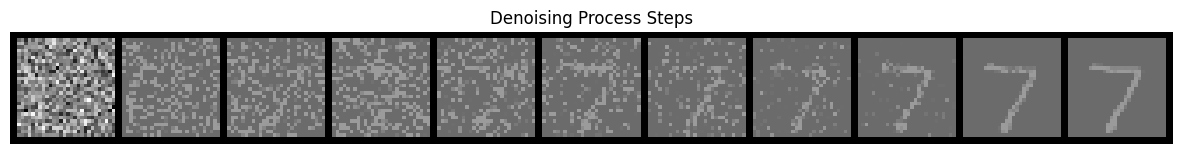

In [75]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def visualize_tensor_images(image_tensor, num_images=4, title=None):
    '''
    Utility function to visualize tensor images.
    '''
    image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())  # Normalize to [0,1]
    image_grid = make_grid(image_tensor[:num_images], nrow=num_images, padding=2, normalize=False)
    plt.figure(figsize=(15, 5))
    plt.imshow(np.transpose(image_grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()


def test_diffusion_model(model, device, test_loader, noise_levels=5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in test_loader:
            print("1",labels)
            images, labels = images.to(device), labels.to(device)
            initial_noise = torch.rand(1, 1, 28, 28).to(device)  # Random noise image

            # Generate a highly noisy version of the first image in the batch
            # initial_noise = images[0:1].clone()
            for _ in range(noise_levels - 1):
                initial_noise = add_noise(initial_noise, noise_factor=0.3)

            # Store each step of the denoising process
            outputs = [initial_noise]
            for i in range(noise_levels - 1, -1, -1):
                current_noisy = add_noise(images[0:1], noise_factor=0.3 * i)
                output = model(current_noisy, labels[0:1])#take the first image and label
                outputs.append(output)

            # Visualize the outputs
            outputs = torch.cat(outputs, 0)  # Concatenate images for visualization
            visualize_tensor_images(outputs, num_images=noise_levels+1, title="Denoising Process Steps")

            break  # Assuming we only want to see the process for the first batch

# Assuming 'model' and 'test_loader' are predefined and model is loaded to 'device'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_diffusion_model(model, device, test_loader, noise_levels=10)




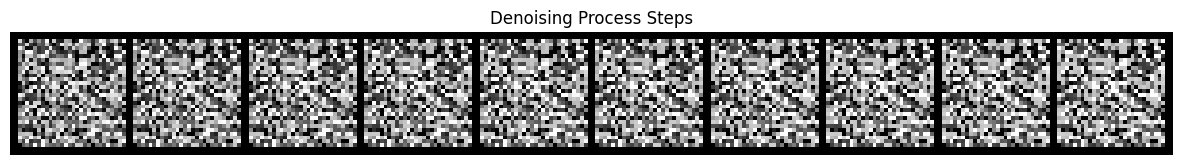

In [81]:
def test_diffusion_model(model, device, test_loader, noise_levels=5):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        initial_noise = torch.rand(1, 1, 28, 28).to(device)  # Random noise image

        label = torch.tensor([2], dtype=torch.long).to(device)  # Example label, for digit '2'
        outputs = []  # Initialize outputs list
        image = initial_noise
        for i in range(10):
            output = model(image, label)
            image = output
            outputs.append(output)

        # Visualize the outputs
        outputs = torch.cat(outputs, 0)  # Concatenate images for visualization
        visualize_tensor_images(outputs, num_images=noise_levels+1, title="Denoising Process Steps")


# Assuming 'model' and 'test_loader' are predefined and model is loaded to 'device'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
test_diffusion_model(model, device, test_loader, noise_levels=10)



sss